<a href="https://colab.research.google.com/github/radiangle/pneumonia-classification/blob/main/image_classification_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lung Image Classification using Convolutional Neural Networking

Reference: 
* CNN: https://medium.com/@himadrisankarchatterjee/a-basic-introduction-to-convolutional-neural-network-8e39019b27c4
* CNN Demo: https://www.youtube.com/watch?v=jztwpsIzEGc
* CNN Example: https://github.com/nicknochnack/ImageClassification/blob/main/Getting%20Started.ipynb
* Dataset: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

1. Building a data pipeline
2. Preprocessing images for deep learning
3. Creating a deep neural network classifier
4. Evaluating model performance
5. Saving the model for deployment

## 1. Setup and Load Data

### A. Install Dependencies and Setup

In [1]:
# pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [2]:
# !pip list

In [3]:
import tensorflow as tf
import os
from matplotlib import pyplot as plt

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
# pip install opencv-python

### B. Image Ready

In [6]:
# remove dodgy images
import cv2
import imghdr

In [7]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!ls drive/MyDrive/datasets/

chest_xray_data


In [9]:
data_dir = 'drive/MyDrive/datasets/chest_xray_data'

In [10]:
os.listdir(os.path.join(data_dir))

['test', 'train', 'val']

In [11]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [12]:
for image_class in os.listdir(data_dir): # image_class: NORMAL, PNEUMONIA
    for image in os.listdir(os.path.join(data_dir, image_class)): # image: individual images in the file
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

Issue with image drive/MyDrive/datasets/chest_xray_data/test/NORMAL
Issue with image drive/MyDrive/datasets/chest_xray_data/test/PNEUMONIA
Issue with image drive/MyDrive/datasets/chest_xray_data/train/NORMAL
Issue with image drive/MyDrive/datasets/chest_xray_data/train/PNEUMONIA
Issue with image drive/MyDrive/datasets/chest_xray_data/val/PNEUMONIA
Issue with image drive/MyDrive/datasets/chest_xray_data/val/NORMAL


### C. Load Data

In [13]:
import numpy as np
from matplotlib import pyplot as plt

In [14]:
train_data = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/datasets/chest_xray_data/train', labels='inferred')

Found 5216 files belonging to 2 classes.


In [15]:
# from tensorflow.keras.preprocessing import image_dataset_from_directory

# train_data_num = image_dataset_from_directory('/content/drive/MyDrive/datasets/chest_xray_data/train', labels='inferred')
# num_images = tf.data.experimental.cardinality(train_data_num).numpy()
# print("Number of images:", num_images)

In [16]:
test_data = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/datasets/chest_xray_data/test', labels='inferred')

Found 624 files belonging to 2 classes.


In [17]:
val_data = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/datasets/chest_xray_data/val', labels='inferred')

Found 16 files belonging to 2 classes.


In [18]:
data_train_data_iterator = train_data.as_numpy_iterator()

In [19]:
# get another batch from the iterator
batch = data_train_data_iterator.next()

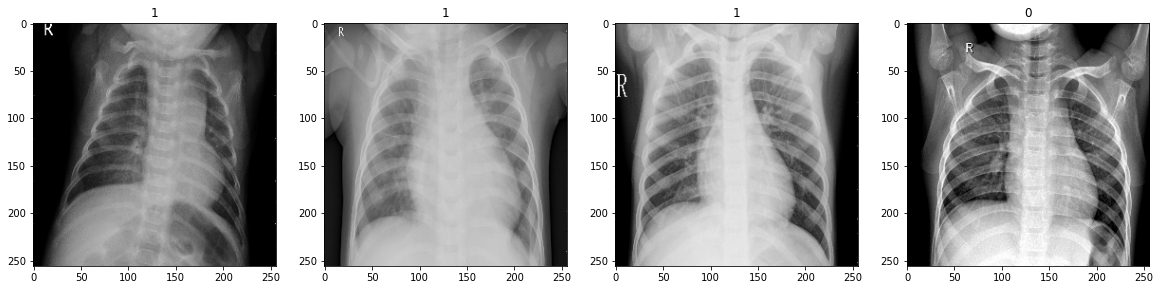

In [20]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx]) # 0: NORMAL, 1: PNEUMONIA

## 2. Preprocess Data

### A. Scale Data

In [21]:
scaled_data_train = train_data.map(lambda x,y: (x/255, y)) # it allows us to perform transformation in pipeline (tensorflow data api)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [22]:
scaled_data_test = test_data.map(lambda x,y: (x/255, y)) # it allows us to perform transformation in pipeline (tensorflow data api)

In [23]:
scaled_data_val = val_data.map(lambda x,y: (x/255, y)) # it allows us to perform transformation in pipeline (tensorflow data api)

In [25]:
# scaled_data_test.as_numpy_iterator().next()

### B. Split Data

In [26]:
train = scaled_data_train
test = scaled_data_test
val = scaled_data_val

## 3. Deep Learning Model

### A. Build Model

In [27]:
# understand the libraries that we are using
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras import regularizers


In [28]:
model = Sequential()

In [29]:
# first convolution block (16 filters, 3 by 3 pixels, stride of one, pass through a relu activation, define input shape)
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Dropout(0.2)) # Add dropout layer - debugging
# second convolution block
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2)) # Add dropout layer
# third convolution block
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2)) # Add dropout layer
# fully connected
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))) # Add L2 regularization
model.add(Dropout(0.5)) # Add dropout layer
# OUTPUT
model.add(Dense(1, activation='sigmoid')) # sigmoid activation function --> define NORMAL(0) & PNEUMONIA (1)

In [30]:
# using tf.optimizers.adam, binary classification
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [31]:
# show CNN steps
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 62, 62, 32)        0

### B. Train Model

In [32]:
logdir='logs'

In [33]:
# save model using callbacks
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [34]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
163/163 [==============================] - 915s 6s/step - loss: 1.2846 - accuracy: 0.8407 - val_loss: 0.6190 - val_accuracy: 0.7500
Epoch 2/20
163/163 [==============================] - 41s 240ms/step - loss: 0.2876 - accuracy: 0.9342 - val_loss: 0.4375 - val_accuracy: 0.8750
Epoch 3/20
163/163 [==============================] - 39s 229ms/step - loss: 0.2537 - accuracy: 0.9427 - val_loss: 0.4427 - val_accuracy: 0.8125
Epoch 4/20
163/163 [==============================] - 38s 225ms/step - loss: 0.2442 - accuracy: 0.9442 - val_loss: 0.3664 - val_accuracy: 0.8125
Epoch 5/20
163/163 [==============================] - 39s 229ms/step - loss: 0.2406 - accuracy: 0.9465 - val_loss: 0.2671 - val_accuracy: 0.9375
Epoch 6/20
163/163 [==============================] - 39s 223ms/step - loss: 0.2224 - accuracy: 0.9484 - val_loss: 0.7905 - val_accuracy: 0.6875
Epoch 7/20
163/163 [==============================] - 38s 222ms/step - loss: 0.2248 - accuracy: 0.9484 - val_loss: 0.5546 - val_accu

In [36]:
hist

### C. Plot Performance

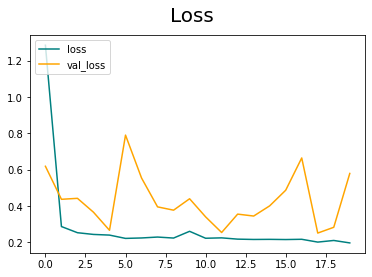

In [37]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

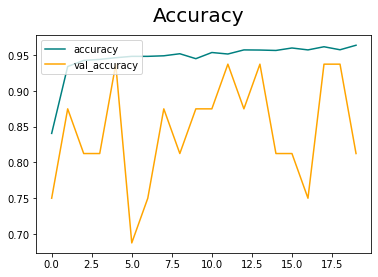

In [64]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## 4. Evaluate Performance

### A. Evaluate

In [39]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [40]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [41]:
test.element_spec

(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [42]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 79ms/step


In [43]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.7288136, shape=(), dtype=float32) tf.Tensor(0.99230766, shape=(), dtype=float32) tf.Tensor(0.7644231, shape=(), dtype=float32)


### B. Test

In [44]:
import cv2

In [ ]:
def predict_normal(num):
    if num > 0.5: 
        return (f'This patient has PNEUMONIA')
    else:
        return (f'This patient does not have PNEUMONIA')


#### TEST NORMAL

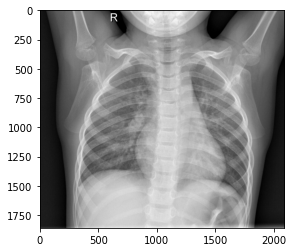

In [65]:
img_normal = cv2.imread("drive/MyDrive/datasets/chest_xray_data/train/NORMAL/IM-0115-0001.jpeg")
plt.imshow(img_normal)
plt.show()

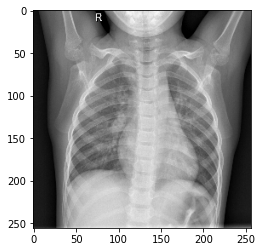

In [66]:
resize = tf.image.resize(img_normal, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [67]:
yhat_normal = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 23ms/step


In [69]:
predict_normal(yhat_normal)

'This patient does not have PNEUMONIA'

#### TEST PNEUMONIA

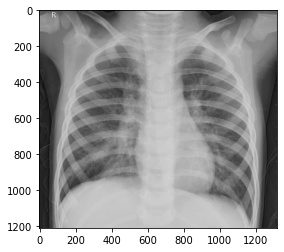

In [60]:
img_pneumonia = cv2.imread("drive/MyDrive/datasets/chest_xray_data/test/PNEUMONIA/person20_virus_51.jpeg")
plt.imshow(img_pneumonia)
plt.show()

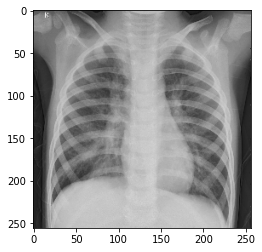

In [61]:
resize = tf.image.resize(img_pneumonia, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [62]:
yhat_pneumonia = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 27ms/step


In [63]:
predict_normal(yhat_pneumonia)

'This patient has PNEUMONIA'

## 5. Save the Model

### A. Save the Model

In [ ]:
# from tensorflow.keras.models import load_model

In [ ]:
# model.save(os.path.join('models','imageclassifier.h5'))

In [ ]:
# new_model = load_model('imageclassifier.h5')

In [ ]:
# new_model.predict(np.expand_dims(resize/255, 0))